# Checagem de dados

Scripts com exemplos de como fazer o carregamento e divisão dos dados de forma estratificada.
 

In [1]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))
from rasterio.coords import BoundingBox

import src.data.preprocess_data as data
#import src.models.unets as unets

import torch

### Definições
Quais tiles e o número de subtiels são definidos a seguir. 

In [2]:
tiles = ['032027', '032026'] 
num_subtiles = 6


Divisão do conjunto de treino, validação e teste, em que cada arquivo em data/processed dos tiles correspondentes são associados a um dos conjuntos.

É feita a estratificação baseada nas máscaras, de acordo com o valor de classe escolhida pelo usuário.

Neste exemplo, é feita pelo tipo.



In [3]:

train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = 'type')



Training set size: 50
Validation set size: 11
Test set size: 11
saved /home/jonathan/UrbanizedAreasSegmentation/config/train_val_test_split-6_subtiles-032027_032026-stratified_by_type.yaml


In [4]:
train_files, val_files, test_files
len(train_files), len(val_files), len(test_files)

(50, 11, 11)

## Checagem de resultados da estratificação

data.check_stratification imprime o número de pixels de cada classe por divisão de conjunto. 

In [5]:
data.check_stratification(train_files+val_files+test_files, num_subtiles=6, stratify_by='type')

data.check_stratification(train_files, num_subtiles=6, stratify_by='type')
data.check_stratification(val_files, num_subtiles=6, stratify_by='type')
data.check_stratification(test_files, num_subtiles=6, stratify_by='type')
1

0 209780441 223027200; 1 592328 223027200; 2 637884 223027200; 3 170864 223027200; 4 11845683 223027200; {0: 0.9406047378974403, 1: 0.0026558554292929293, 2: 0.0028601175103305787, 3: 0.0007661128328741965, 4: 0.05311317633006198}
0 149598214 154880000; 1 290244 154880000; 2 339459 154880000; 3 34414 154880000; 4 4617669 154880000; {0: 0.9658975594008264, 1: 0.0018739927685950412, 2: 0.0021917549070247936, 3: 0.0002221978305785124, 4: 0.029814495092975207}
0 31117282 34073600; 1 148655 34073600; 2 182883 34073600; 3 50737 34073600; 4 2574043 34073600; {0: 0.9132372863448535, 1: 0.004362761786250939, 2: 0.005367293153643877, 3: 0.0014890413692712247, 4: 0.07554361734598046}
0 29064945 34073600; 1 153429 34073600; 2 115542 34073600; 3 85713 34073600; 4 4653971 34073600; {0: 0.8530048189800902, 1: 0.004502870257325319, 2: 0.0033909537002253945, 3: 0.002515525216003005, 4: 0.13658583184635611}


1

In [6]:
train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = '')

Training set size: 50
Validation set size: 11
Test set size: 11
saved /home/jonathan/UrbanizedAreasSegmentation/config/train_val_test_split-6_subtiles-032027_032026.yaml


In [7]:
data.check_stratification(train_files+val_files+test_files, num_subtiles=6, stratify_by='')

data.check_stratification(train_files, num_subtiles=6, stratify_by='')
data.check_stratification(val_files, num_subtiles=6, stratify_by='')
data.check_stratification(test_files, num_subtiles=6, stratify_by='')

0 209780441 223027200; 1 592328 223027200; 3 560797 223027200; 8 3482885 223027200; 9 8362798 223027200; 2 77087 223027200; 5 144892 223027200; 6 2539 223027200; 7 2296 223027200; 4 21137 223027200; {0: 0.9406047378974403, 1: 0.0026558554292929293, 3: 0.002514478054694674, 8: 0.015616413603363178, 9: 0.03749676272669881, 2: 0.0003456394556359045, 5: 0.0006496606691919191, 6: 1.1384261650596878e-05, 7: 1.029470844811754e-05, 4: 9.47731935835629e-05}
0 147683318 154880000; 1 397088 154880000; 3 360958 154880000; 8 2290989 154880000; 9 4022504 154880000; 2 49047 154880000; 5 64860 154880000; 6 2539 154880000; 7 2296 154880000; 4 6401 154880000; {0: 0.9535338197314049, 1: 0.0025638429752066114, 3: 0.002330565599173554, 8: 0.014792026084710743, 9: 0.025971745867768594, 2: 0.0003166774276859504, 5: 0.000418775826446281, 6: 1.6393336776859503e-05, 7: 1.4824380165289256e-05, 4: 4.132877066115702e-05}
0 31714697 34073600; 1 115540 34073600; 2 11566 34073600; 3 119395 34073600; 8 475981 34073600

{0: 0.8916705601990984,
 9: 0.08047086307287754,
 1: 0.0023390542824943653,
 3: 0.0023608893688955674,
 8: 0.021010841237791133,
 2: 0.00048348281367392937,
 5: 0.0015755893125469571,
 4: 8.871971262208866e-05}

## Salvar e carregar

Um arquivo yaml é salvo automaticamente.


In [8]:

train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.7, 
                                                                    val_size = 0.15, 
                                                                    stratify_by = 'type')


Loading:  <function yaml_filename at 0x76e05d6aa200>
File already saved, loading it.


In [9]:
train_dataset = data.SubtileDataset(train_files, 
                    num_subtiles = num_subtiles, 
                    classes_mode = 'type', 
                    patch_size=(256, 256), 
                    stride=128, 
                    augment = False, 
                    augment_transform = None, 
                    return_imgidx = False,
                    return_nans=False,
                    debug=False)


/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=1760_y=0.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032026/6x6_subtiles/S2-16D_V2_032026_x=1760_y=3520.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=5280_y=7040.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=0_y=1760.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=7040_y=1760.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=5280_y=8800.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=1760_y=1760.tif
/home/jonathan/UrbanizedAreasSegmentation/data/processed/S2-16D_V2_032027/6x6_subtiles/S2-16D_V2_032027_x=7040_y=5280.tif
/home/jonathan/UrbanizedAreasS

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import src.data.subtile_composition as subtile_composition

x, y:  0 0 subtiles: 1760 0
x, y:  0 128 subtiles: 1760 0


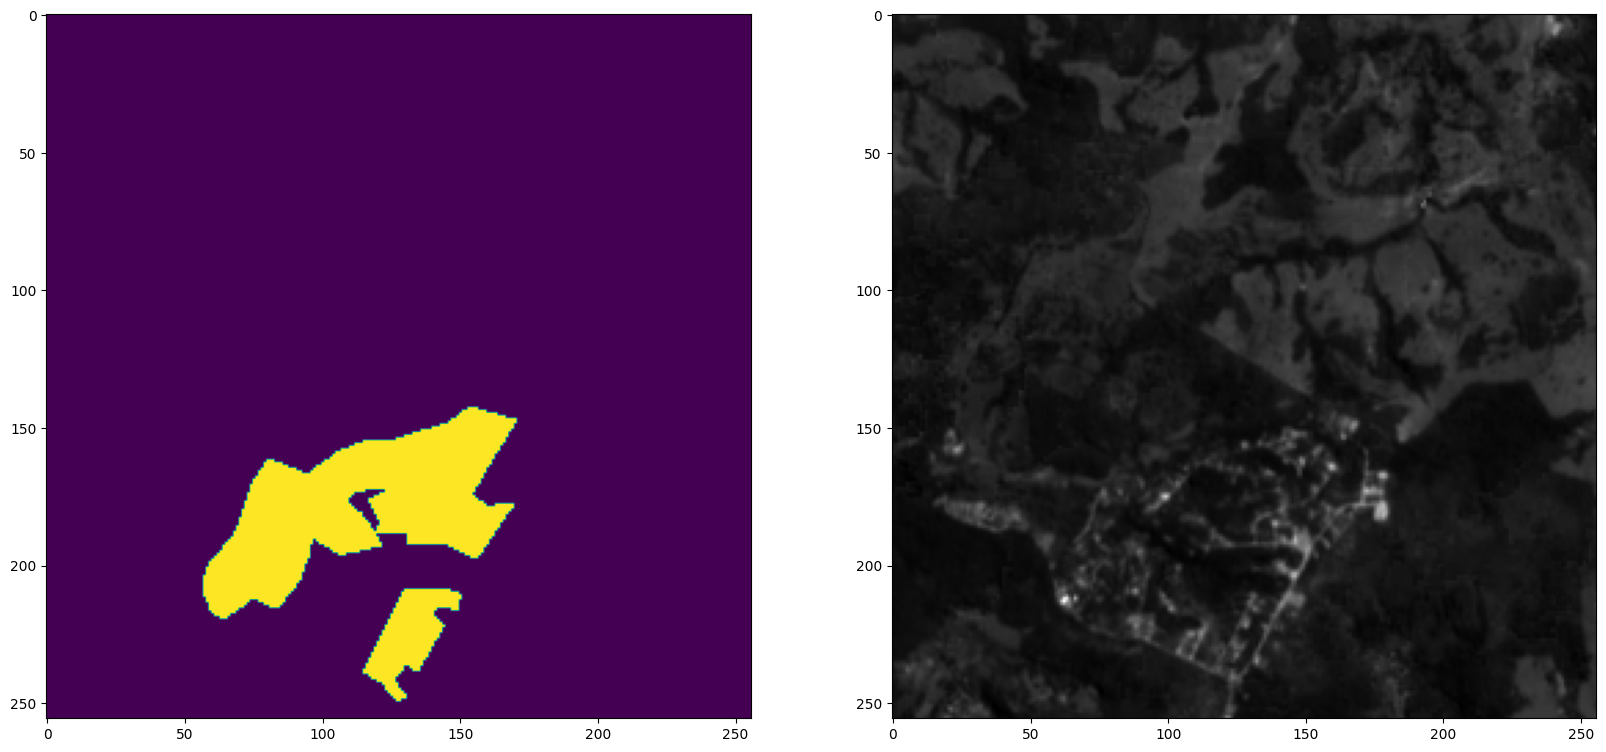

x, y:  0 256 subtiles: 1760 0


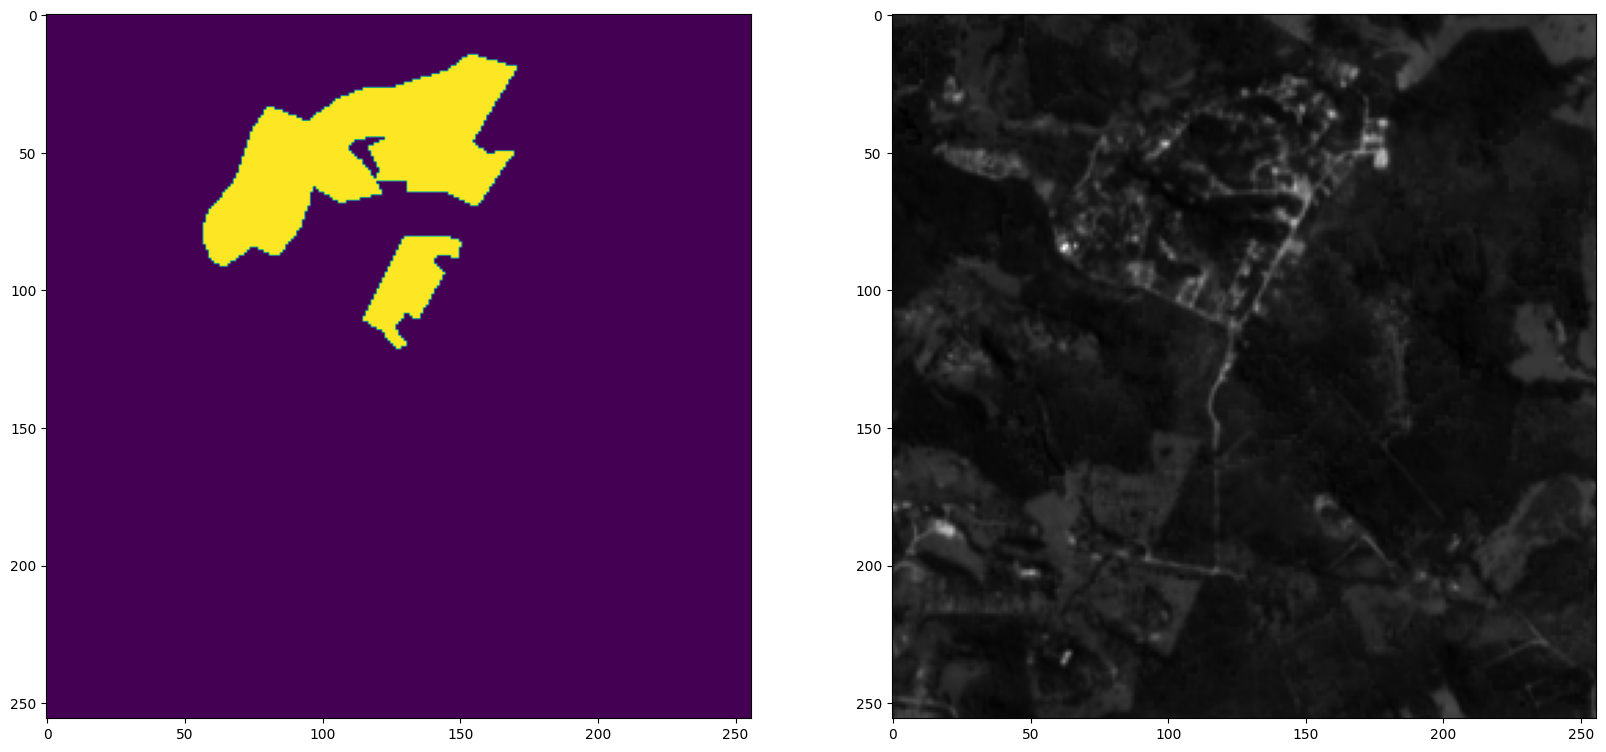

x, y:  0 384 subtiles: 1760 0


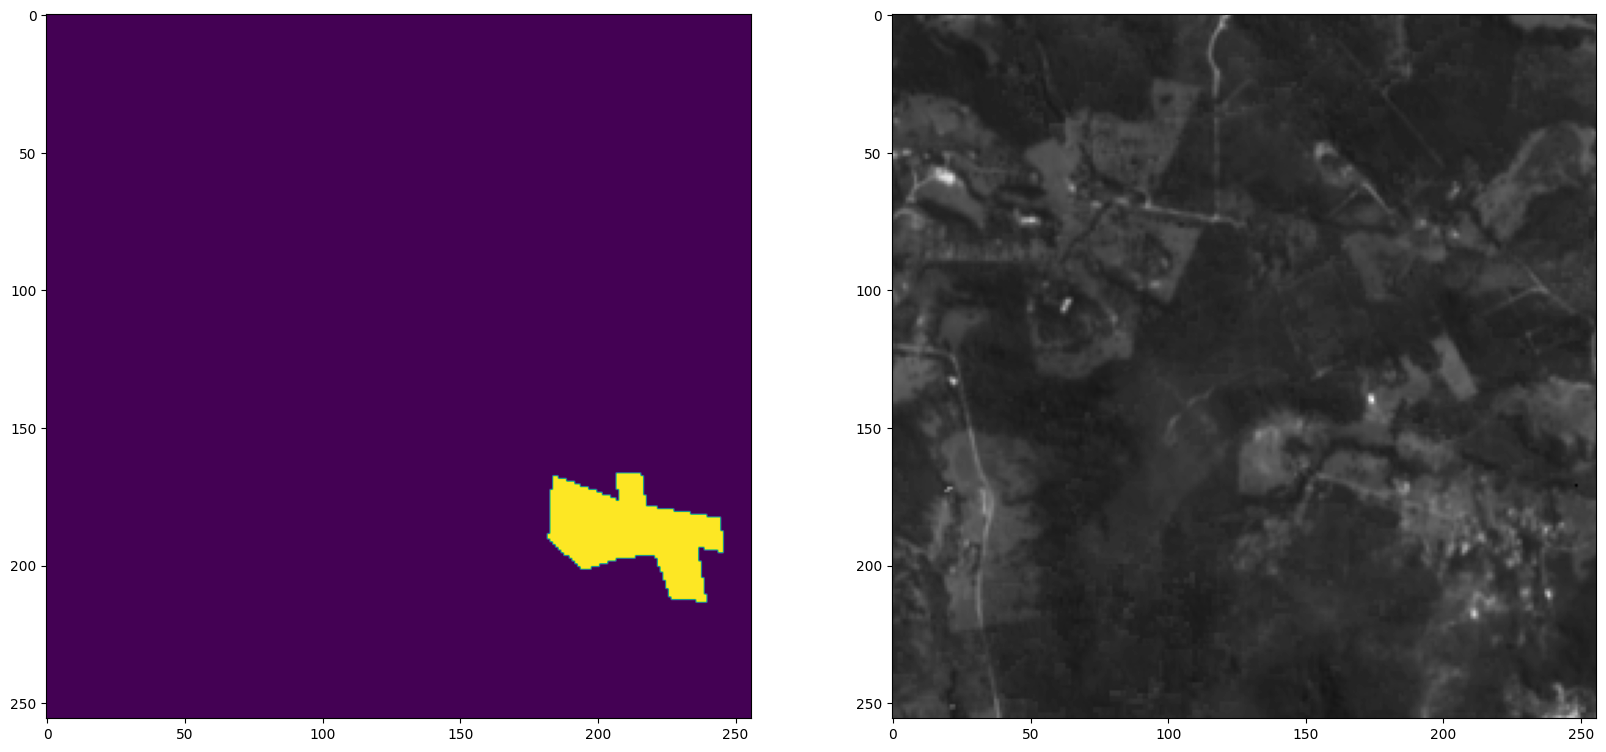

x, y:  0 512 subtiles: 1760 0


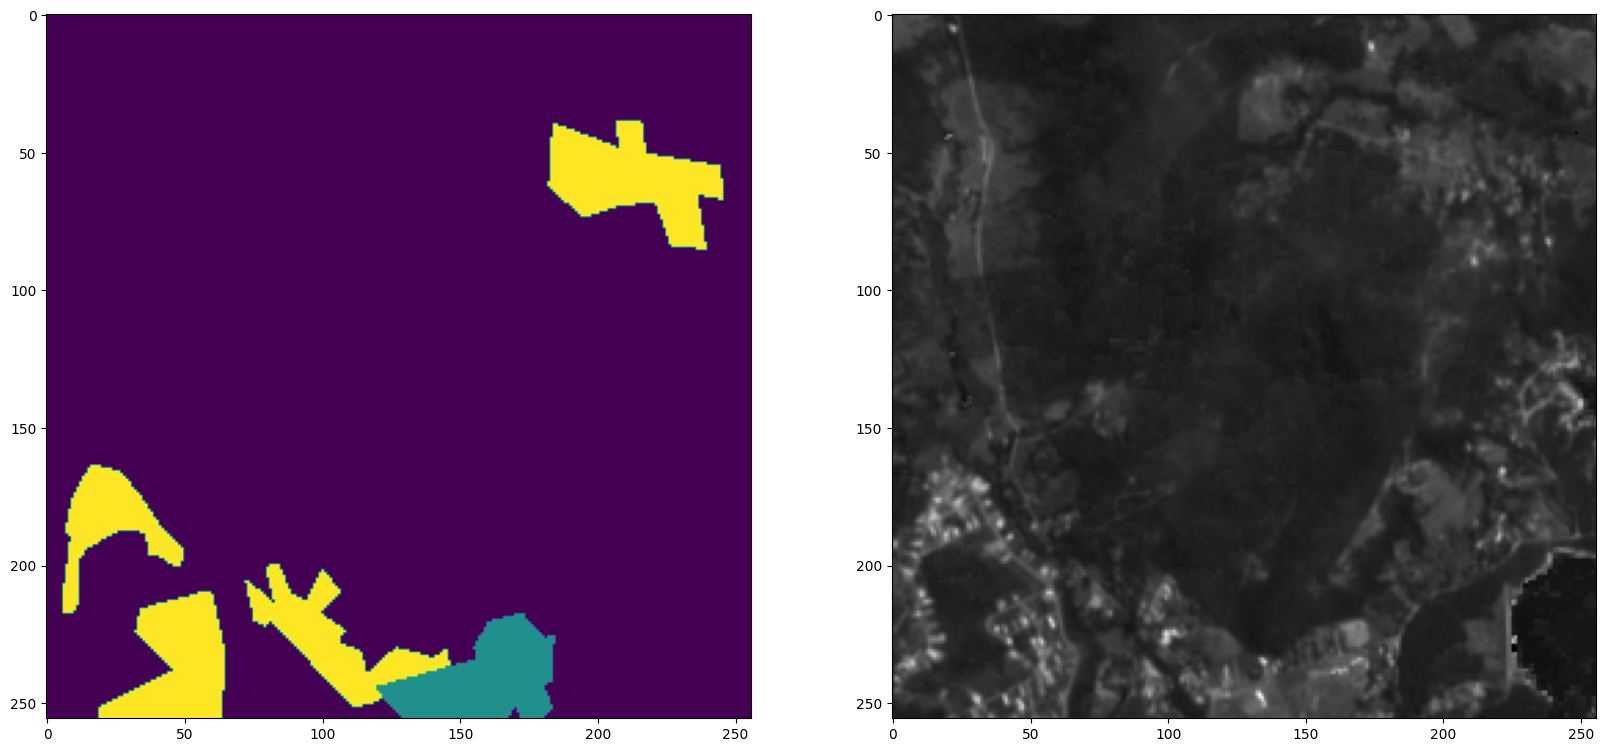

x, y:  0 640 subtiles: 1760 0


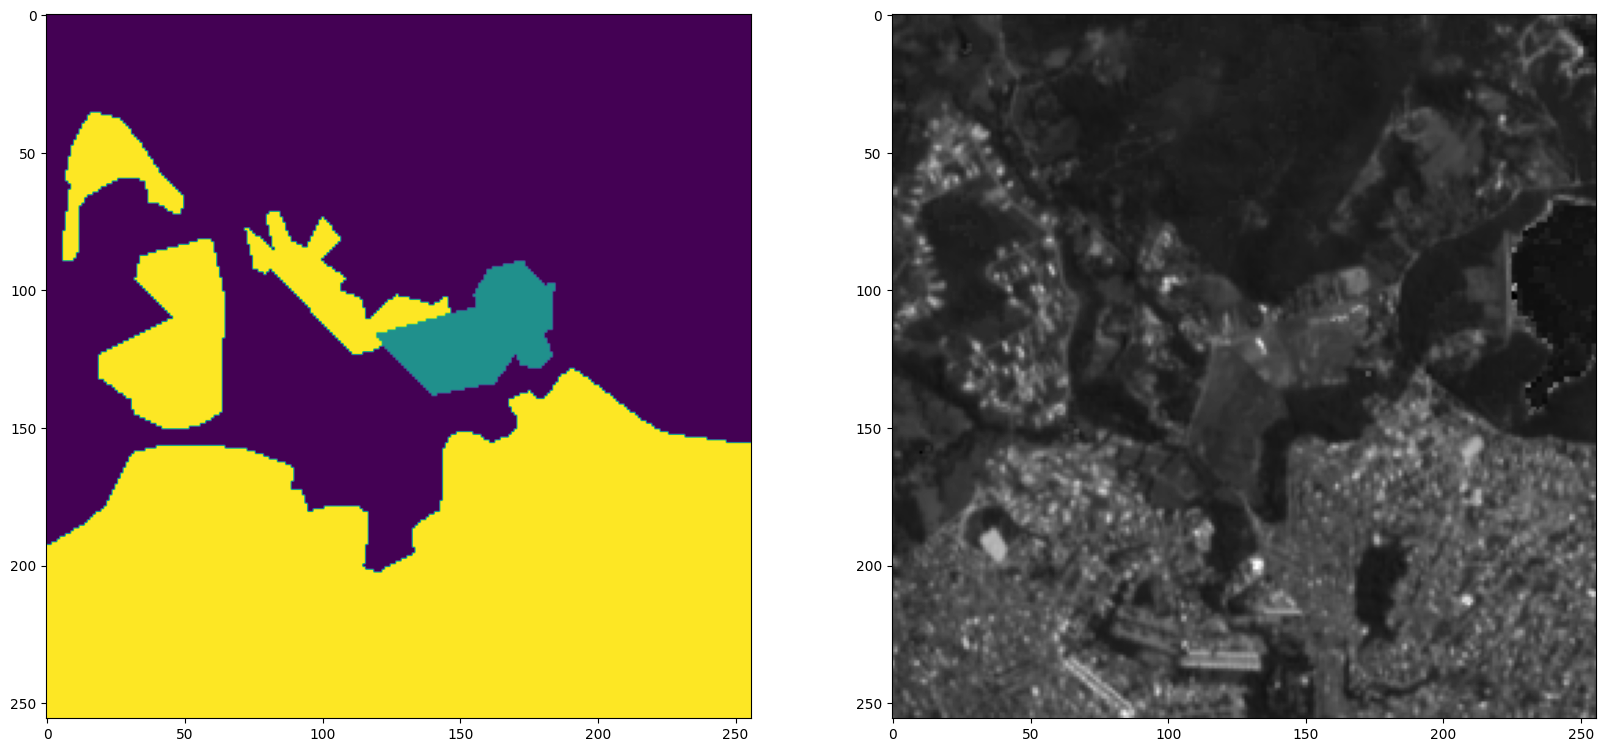

In [11]:
if 1:
    i = 0
    for img, mask in train_dataset:
        if  (mask != 0).any():
            #subtile_composition.display_images(img)
            plt.figure(figsize=(20,20))
            plt.subplot(1,2,1)
            plt.imshow(mask.squeeze())
            plt.subplot(1,2,2)
            plt.imshow(img[2].squeeze(),cmap='gray')
            plt.show()
            i+=1
        if 0:
            break

            torch.zeros_like(img)
            for i in range(img.shape[0]):
                img[i] = torch.from_numpy(subtile_composition.interpolate_nan(np.array(img[i]), 
                                                                            interpolation_method='linear', 
                                                                            value_type='regular'
                                                                            )
                                        )
        
        
        if i == 5:
            pass
            break
    #img,mask = next(train_dataset)

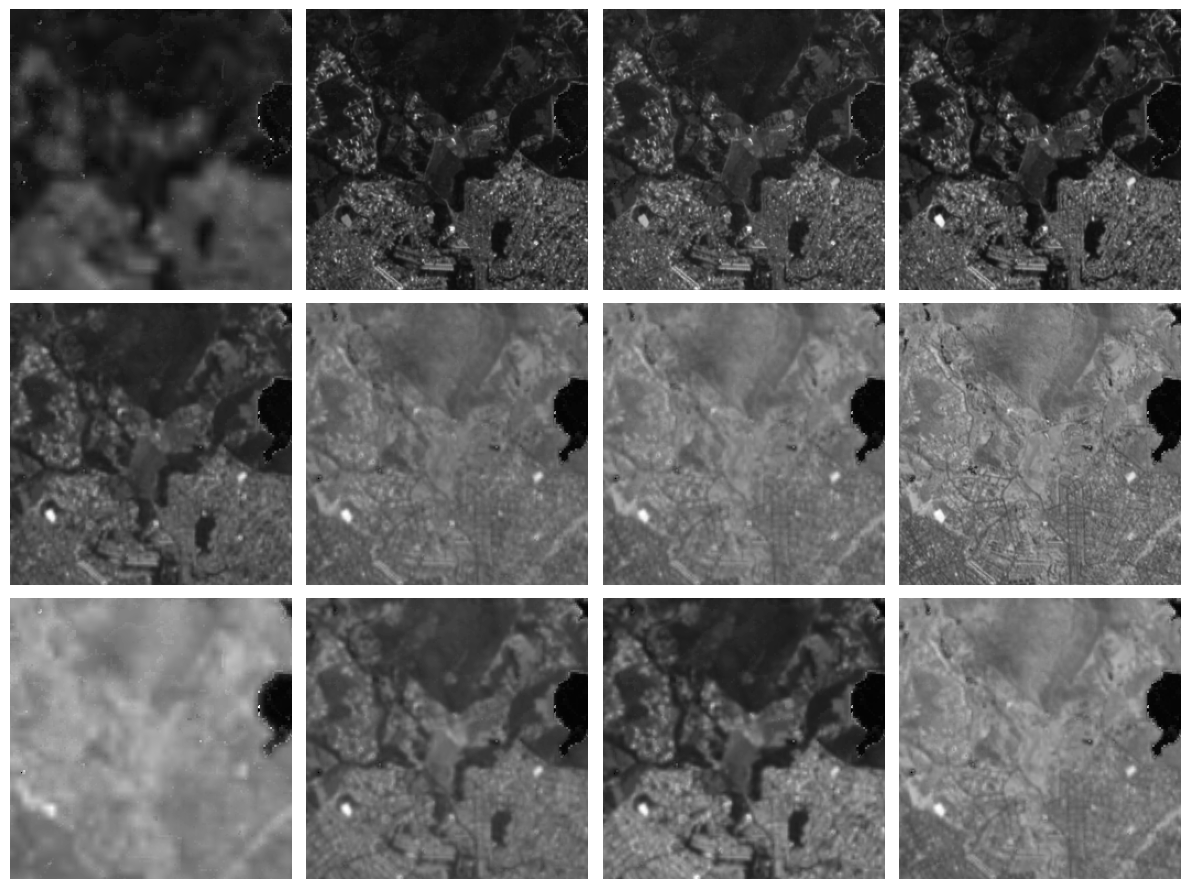

In [12]:

subtile_composition.display_images(img)


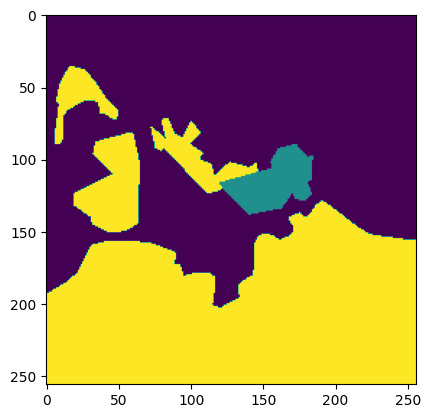

In [13]:
plt.imshow(mask.squeeze())

In [14]:
1/0

ZeroDivisionError: division by zero

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon





# Create a list of polygons
polygons = [
    Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
    Polygon([(2, 2), (2, 3), (3, 3), (3, 2)])
]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': polygons})

# Print the GeoDataFrame
print(gdf)

0.16666666666666666

In [ ]:

train_dataset = data.ImageDataset(files = train_files, 
                            mask_filename = "masks/raster_aurb_032027.tif", 
                            num_classes = num_classes,
                            subtile_size = 10560/6,
                            mean = mean, 
                            std = std,
                            patch_size = (patch_size, patch_size),
                            stride = stride,
                            augment = data_aug)